# Statische modellbasierte Optimierung Spritzgießprozess

Lade Bibliotheken

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd

# Füge Pfad der Toolbox zum Suchpfad hinzu
path_dim = Path.cwd().parents[2]
sys.path.insert(0, path_dim.as_posix())

from DIM.optim.control_optim import StaticProcessOptimizer

Lade Daten und bereits gebildetes Modell

In [2]:
data = pd.read_hdf(Path('DIM_20221104.h5'),'modelling_data')
models = pkl.load(open(Path('static_PIM_models.pkl'),'rb'))
model = models[22]['val']

Initialisiere den Optimierer zur Berechnung der optimalen einzustellenden Maschinenparameter

In [3]:
process_optim = StaticProcessOptimizer(model)

Definiere an den Optimierer zu übergebende Optionen

In [4]:
Q_target =  pd.DataFrame.from_dict({'Gewicht': [8.15]}) # Zielqualität
fix_inputs =  pd.DataFrame.from_dict({'T_wkz_0': [48.15]}) # Modelleingänge die nicht variiert werden können

Normiere

In [5]:
Q_target_norm = model.MinMaxScale(Q_target)
fix_inputs_norm = model.MinMaxScale(fix_inputs)
data_norm = model.MinMaxScale(data)

In [6]:
res_norm = process_optim.optimize(Q_target_norm,fix_inputs_norm)

Unnormalize results and print

In [7]:
res = model.MinMaxScale(res_norm,reverse=True)
print(res)

   v_inj_soll  V_um_soll  T_wkz_soll  T_wkz_0          loss
0   16.516996  13.892648   32.834539    48.15  2.729185e-19


Gleiche Ergebnis mit den vohandenen Messdaten ab. Der nächste Arbeitspunkt ist v_inj_soll=17, V_um_soll=14, T_wkz_soll=32

In [8]:
data_stp = data.loc[(data['v_inj_soll']==17) & (data['V_um_soll']==14) & (data['T_wkz_soll']==32),['T_wkz_0','Gewicht']]

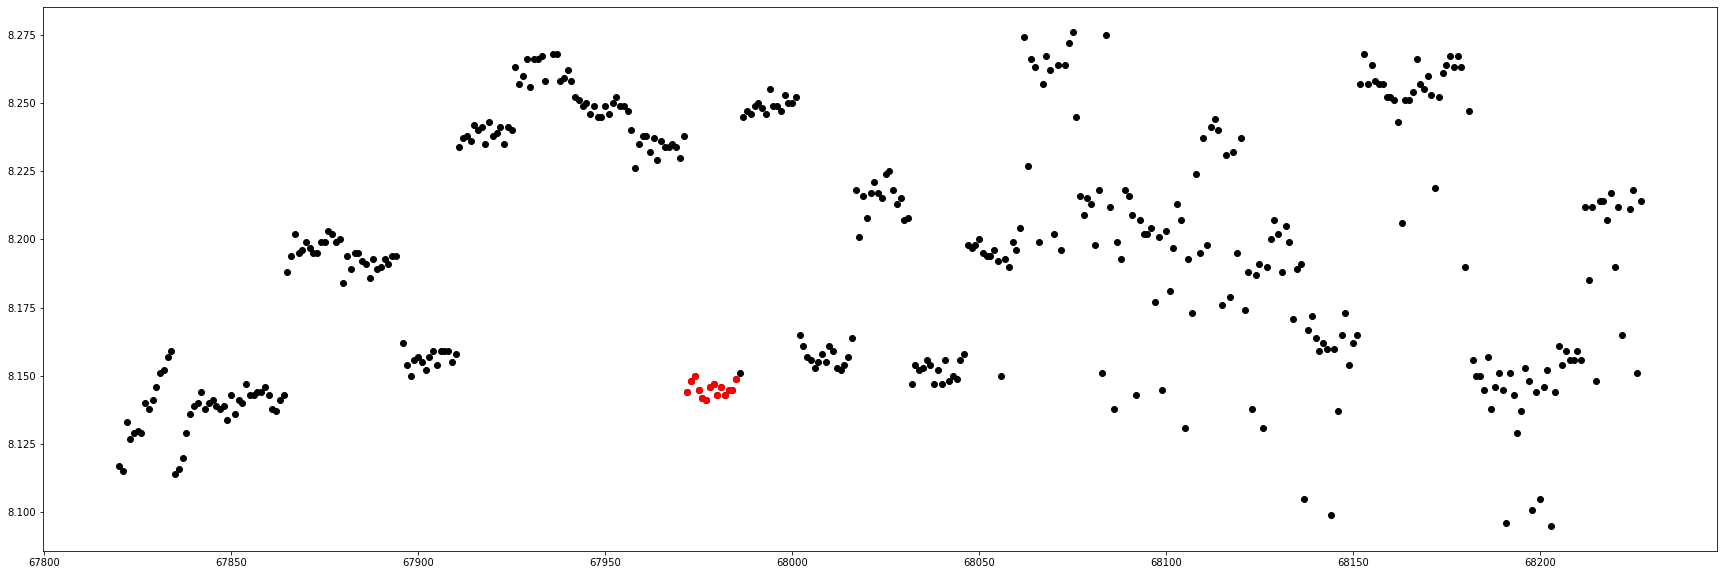

In [9]:
import seaborn as sns
fig,ax = plt.subplots(1,1)
fig.set_size_inches((30,10))
ax.plot(data.index,data['Gewicht'],color='k',linestyle='None',marker='o')
ax.plot(data_stp.index,data_stp['Gewicht'],color='r',linestyle='None',marker='o')
#ax.set_xlim([data.index.min(),data.index.max()])
#sns.stripplot(data=data_stp,x=data_stp.index,y='Gewicht',ax=ax[1],size=20)

Das diese spezifische Lösung gefunden wurde, liegt an der Initialisierungsabhängigkeit des Optimierungsproblems. Werden keine Startwerte für v_inj_soll, V_um_soll, T_wkz_soll vorgegeben, werden diese mit Null initialisiert. Es ist sinnvoll, Vorwissen in die Initialisierung einfließen zu lassen. Beispielsweise kann das Optimierungsproblem mehrfach gelöst werden, mit jeweils einer anderen gemessenen Maschineneinstellung als Initialisierung

In [10]:
inits = data.groupby('Setpoint').first()
inits_norm = model.MinMaxScale(inits)
print(inits[model.u_label])

          v_inj_soll  V_um_soll  T_wkz_soll    T_wkz_0
Setpoint                                              
0               14.0       13.5        29.0  33.646656
1               20.0       14.0        29.0  43.137909
2               17.0       14.0        29.0  44.480724
3               17.0       13.5        29.0  44.511242
4               20.0       13.5        29.0  45.113983
5               14.0       14.0        29.0  44.915615
6               20.0       13.0        29.0  44.747761
7               14.0       13.0        29.0  45.190281
8               17.0       13.0        29.0  44.923244
9               20.0       13.0        32.0  38.308357
10              17.0       14.0        32.0  47.631760
11              17.0       13.0        32.0  48.234501
12              14.0       14.0        32.0  48.623611
13              14.0       13.5        32.0  48.371834
14              20.0       14.0        32.0  48.539688
15              20.0       13.5        32.0  48.577835
16        

In [11]:
res = []

for stp in inits_norm.index:
    input_init_norm = inits_norm.loc[[stp],['v_inj_soll', 'V_um_soll', 'T_wkz_soll']]
    res.append(process_optim.optimize(Q_target=Q_target_norm,
                                 fix_inputs=fix_inputs_norm,
                                 input_init = input_init_norm))
    
    

Konkateniere Ergebnisse und skaliere auf den ursprünglichen Wertebereich

In [12]:
res = pd.concat(res)
res = model.MinMaxScale(res,reverse=True)
print(res)

   v_inj_soll  V_um_soll  T_wkz_soll  T_wkz_0          loss
0   14.733146  13.738667   33.618319    48.15  7.296787e-17
0   20.313512  14.211397   30.519729    48.15  1.035847e-17
0   17.308199  14.224890   30.978890    48.15  1.450063e-17
0   18.045885  13.918283   34.368757    48.15  9.374127e-18
0   20.411517  14.017439   31.665706    48.15  1.298615e-18
0   14.384350  14.217924   31.404980    48.15  3.206540e-19
0   22.522223  13.891887   32.236309    48.15  3.773054e-22
0   13.014217  13.532547   34.369046    48.15  3.060133e-19
0   15.746171  13.800175   33.489387    48.15  9.277826e-22
0   20.502462  13.934615   32.546032    48.15  2.764266e-19
0   16.976897  14.024224   32.000312    48.15  1.405235e-19
0   14.008948  13.654356   33.991525    48.15  8.767879e-18
0   14.005426  14.022961   32.184810    48.15  2.015605e-22
0   13.395586  13.714351   33.418994    48.15  2.131395e-17
0   19.992993  13.990756   31.960105    48.15  2.158024e-20
0   19.681595  13.951901   32.393001    

Die Lösungsvorschläge gehen teilweise über den Wertebereich hinaus, in dem Daten vorgelegen haben. Das Modell befindet sich hier also im Extrapolationsbereich und ist damit nicht vertrauenswürdig. Um nur Lösungen zu generieren, die innerhalb eines gewissenen Wertebereichs liegen, kann das Optimierungsproblem durch Nebenbedingungungen erweitert werden. 

In [13]:
constraints_norm = []
    
for u in set(model.u_label)-set(['T_wkz_0']):
    constraints_norm.append((u,'>'+str(data_norm[u].min())))
    constraints_norm.append((u,'<'+str(data_norm[u].max())))   
print(constraints_norm)

[('v_inj_soll', '>-1.0'), ('v_inj_soll', '<1.0'), ('T_wkz_soll', '>-1.0'), ('T_wkz_soll', '<1.0'), ('V_um_soll', '>-1.0'), ('V_um_soll', '<1.0')]


Löse das Optimierungsproblem erneut mit Nebenbedingungen

In [14]:
res = []

for stp in inits_norm.index:
    input_init_norm = inits_norm.loc[[stp],['v_inj_soll', 'V_um_soll', 'T_wkz_soll']]
    res.append(process_optim.optimize(Q_target=Q_target_norm,
                                 fix_inputs=fix_inputs_norm,
                                 input_init = input_init_norm,
                                 constraints=constraints_norm))

In [16]:
res = pd.concat(res)
res = model.MinMaxScale(res,reverse=True)
print(res)

   v_inj_soll  V_um_soll  T_wkz_soll  T_wkz_0          loss
0   16.582819  13.832138   33.592099    48.15  2.440774e-16
0   17.134785  13.886502   32.979706    48.15  4.151803e-17
0   17.054672  13.869681   34.387186    48.15  1.939718e-17
0   16.470921  13.840167   34.493467    48.15  1.030529e-17
0   17.501245  13.884026   34.180932    48.15  2.578305e-16
0   17.177249  13.857048   33.643385    48.15  2.997140e-17
0   20.000000  13.000000   35.000000    48.15  2.643969e-01
0   15.558404  13.776012   33.733137    48.15  9.679780e-18
0   15.682749  13.798270   33.478457    48.15  1.614837e-20
0   14.363714  13.708044   33.699338    48.15  6.110015e-17
0   16.808293  13.944135   32.491860    48.15  7.019701e-18
0   15.861666  13.806802   33.467849    48.15  4.569797e-18
0   14.495102  13.939415   32.529350    48.15  9.151627e-17
0   15.302106  13.803570   33.293218    48.15  2.427191e-18
0   19.414724  13.949699   32.442442    48.15  4.491553e-18
0   16.487845  13.845988   33.260260    

Alle Lösungen befinden sich nun innerhalb der vorgegebenen Grenzen. Dafür existieren einige sehr schlechte Lösungen, hier wollte der Solver bessere Lösungen außerhalb des eingeschränkten Wertebereichs finden, durfte aber nicht. Das Einschränken des Lösungraums um die Lösung eindeutig zu machen oder die Auswahl einer aus vielen Lösungen richtet sich nach der konkreten Anwendung.